# Practical Lab 3: Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

**Author**

Zhimin Xiong 9067935

**Introduction**

This practical lab is to work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand.

**Imports**

* note: all the libraries required to run the code cells in this notebook are listed in the requirements.txt. To test on a different machine, run ```pip install -r requirements.txt```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from tensorflow.keras import Sequential, layers, optimizers
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

## Get Data

In [3]:
# define base directory
data_dir = "data/dogs_vs_cats_small"
data_dir_train = data_dir + "/train"

# List of filenames
cat_files = os.listdir(data_dir_train + "/cat")
dog_files = os.listdir(data_dir_train + "/dog")

## EDA

In [4]:
print(f"Number of dog images: {len(dog_files)}")
print(f"Number of cat images: {len(cat_files)}")

Number of dog images: 2500
Number of cat images: 2500


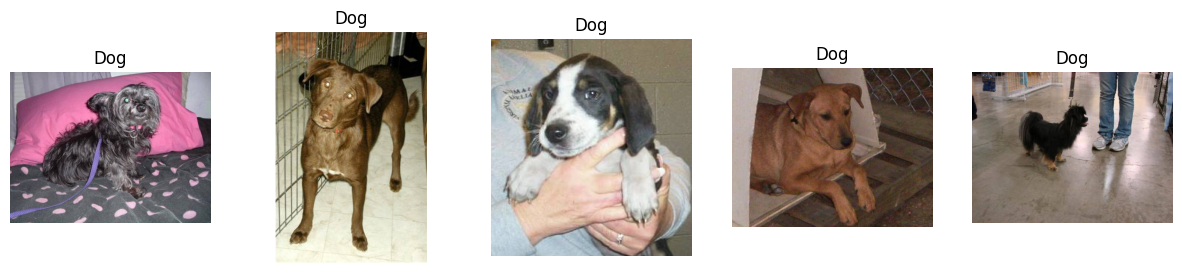

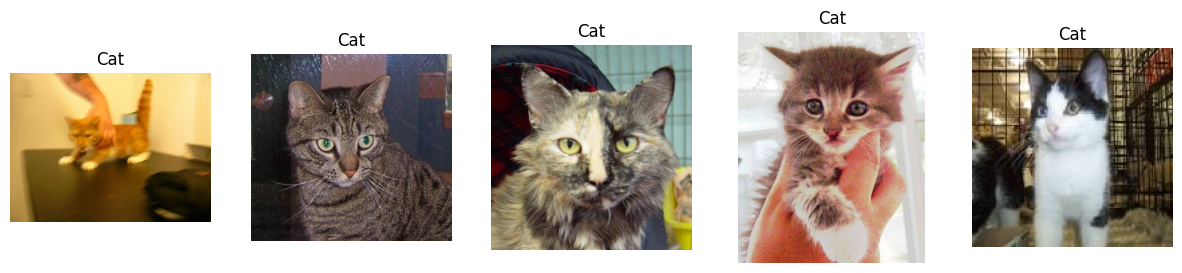

In [4]:
# Display 5 images for dog and cat
from PIL import Image

def show_images(image_list, folder, label, n=5):
    plt.figure(figsize=(15,3))
    for i in range(n):
        img_path = data_dir_train +"/" + folder + "/" + image_list[i]
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    plt.show()

# Show some dog and cat images
show_images(dog_files, "dog", "Dog")
show_images(cat_files, "cat", "Cat")


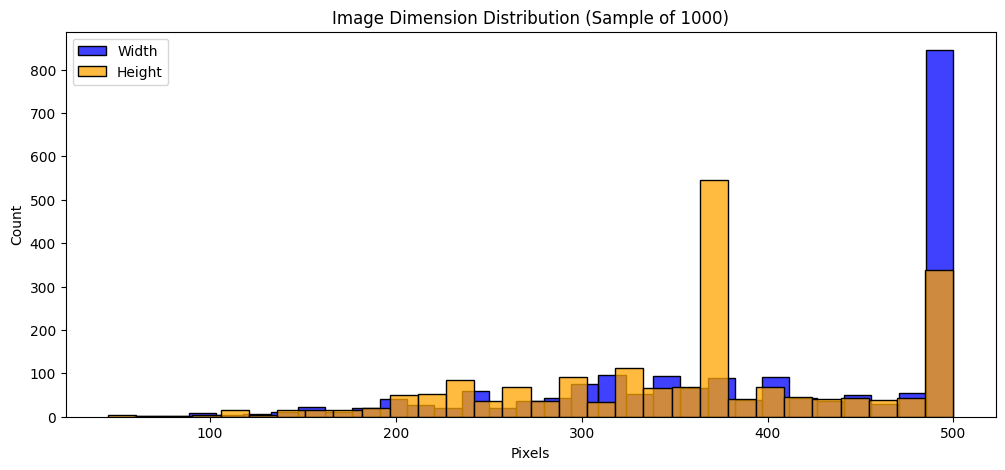

In [5]:
# Check image shapes
image_shapes = []

for img_file in cat_files[:1000]:  # sample 1000 for speed
    img_path = os.path.join(data_dir_train, "cat", img_file)
    with Image.open(img_path) as img:
        image_shapes.append(img.size)  # (width, height)

for img_file in dog_files[:1000]:  # sample 1000 for speed
    img_path = os.path.join(data_dir_train, "dog", img_file)
    with Image.open(img_path) as img:
        image_shapes.append(img.size)  # (width, height)

widths, heights = zip(*image_shapes)

# Plot size distribution
plt.figure(figsize=(12, 5))
sns.histplot(widths, bins=30, color='blue', label='Width')
sns.histplot(heights, bins=30, color='orange', label='Height')
plt.title("Image Dimension Distribution (Sample of 1000)")
plt.legend()
plt.xlabel("Pixels")
plt.show()

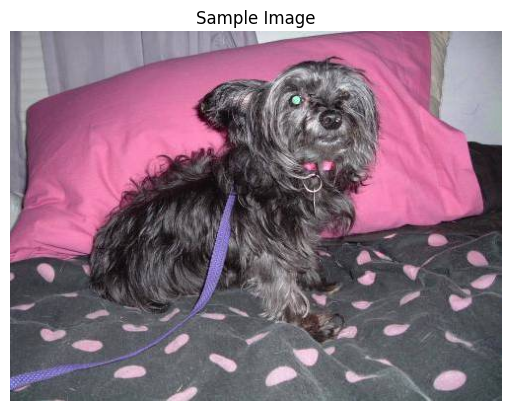

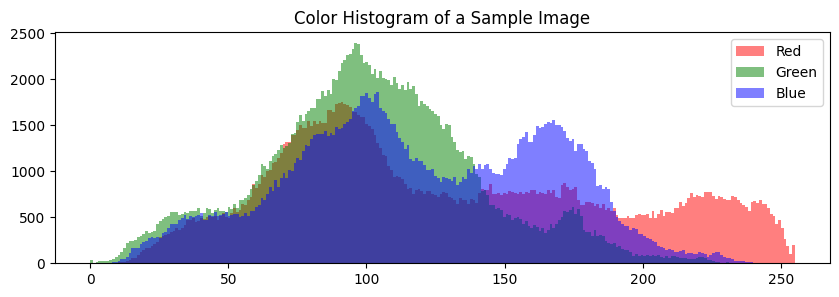

In [6]:
# Check color histogram of a sample image
sample_img = Image.open(os.path.join(data_dir_train, "dog", dog_files[0]))
plt.imshow(sample_img)
plt.axis('off')
plt.title("Sample Image")
plt.show()

# RGB histograms
r, g, b = sample_img.split()
plt.figure(figsize=(10, 3))
plt.hist(np.array(r).flatten(), bins=256, color='red', alpha=0.5, label='Red')
plt.hist(np.array(g).flatten(), bins=256, color='green', alpha=0.5, label='Green')
plt.hist(np.array(b).flatten(), bins=256, color='blue', alpha=0.5, label='Blue')
plt.title("Color Histogram of a Sample Image")
plt.legend()
plt.show()

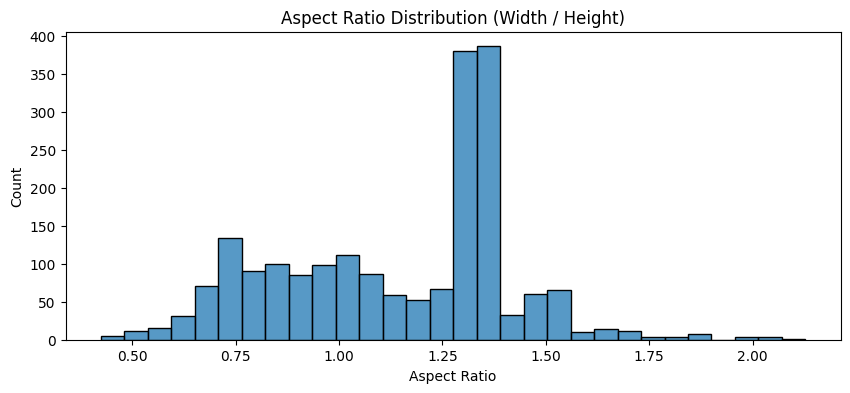

In [7]:
# Check image aspect ratios
aspect_ratios = [w/h for w, h in image_shapes]

plt.figure(figsize=(10, 4))
sns.histplot(aspect_ratios, bins=30)
plt.title("Aspect Ratio Distribution (Width / Height)")
plt.xlabel("Aspect Ratio")
plt.show()


**Insight**
* Images have different sizes 
* Images are colorful instead of grayscale

## Train Two Networks

### Generate the train / Validation dataset

In [5]:
# Parameters
image_size = (150, 150)
batch_size = 32

# ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=["train"],
    class_mode=None,  # we use filenames for labels
    shuffle=False
)

# Use tf.keras.utils.image_dataset_from_directory for better performance
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/train",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/validation",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

Found 5000 images belonging to 1 classes.
Found 5000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Common Functions

In [ ]:
# function to reate a callback to save the best model version
def model_checkpoint_callback(filepath):
    return ModelCheckpoint(
        filepath=filepath,         # Filepath to save
        monitor='val_accuracy',           # Metric to monitor
        save_best_only=True,              # Only save when it's the best so far
        save_weights_only=False,          # Save full model (change to True if you want weights only)
        mode='max',                       # 'max' for accuracy, 'min' for loss
        verbose=1                         # Show logs
    )

In [21]:
# function to get true labels and predicted probabilities
def evaluate(model):
    # recreate the dataset for prediction
    predict_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir + "/test",
        labels='inferred',
        label_mode='binary',
        image_size=image_size,
        batch_size=batch_size,
        shuffle=False
    )
    predict_ds = predict_ds.prefetch(tf.data.AUTOTUNE)
    
    # Track everything
    y_true = []
    y_pred_prob = []
    images_list = []

    for images, labels in predict_ds:
        preds = model(images, training=False).numpy().flatten()
        y_true.extend(labels.numpy().tolist())
        y_pred_prob.extend(preds.tolist())
        images_list.extend(images.numpy())  # Save images

    # Convert everything
    y_true = np.array(y_true).flatten()
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob > 0.5).astype(int)
    images_array = np.array(images_list)

    return (y_true, y_pred, y_pred_prob, images_array)

In [8]:
# Function to calculate and display Accuracy, Confusion Matrix, Precision, Recall, F1
def display_performance(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print("✅ Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    print("\n📊 Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [9]:
# Plot the Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# Plot Training & Validation Loss / Accuracy Over Epochs
def plot_loss_accuracy_over_pochs(hist1, hist2):
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]

    # Then plot like normal
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(combined_history['accuracy'], label='Training Accuracy')
    plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Combined Training + Fine-tuning Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(combined_history['loss'], label='Training Loss')
    plt.plot(combined_history['val_loss'], label='Validation Loss')
    plt.title('Combined Training + Fine-tuning Loss')
    plt.legend()

    plt.show()

In [11]:
# plot misclassfied images
def plot_misclassified(y_pred, y_true, images_array):
    #Find the indices of incorrect predictions
    incorrect_indices = np.where(y_pred != y_true)[0]
    np.random.shuffle(incorrect_indices)
    # Show 9 misclassified images
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(incorrect_indices[:9]):
        plt.subplot(3, 3, i + 1)
        img = images_array[idx].astype("uint8")
        plt.imshow(img)
        plt.title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### 1. Feedforward Neural Network
**Define model**

In [ ]:
input_shape = (150, 150, 3)

# Load VGG16 without the fully connected layers on top
base_model_feedforward = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
#Freeze the Convolutional Base
base_model_feedforward.trainable = False

# Define Feedforward Neural Network Model
model_feedforward = Sequential([
    base_model_feedforward,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')       # Binary classification
])

model_feedforward.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model_feedforward.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,713 (60.16 MB)

 Trainable params: 1,057,025 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train model**

In [ ]:
# Path to save feedforward best model
best_model_feedforward_path = "models/best_model_feedforward.keras"
# Call back to save the best model version
checkpoint_cb_feedforward = model_checkpoint_callback(best_model_feedforward_path)

# Train the Model
history_feedforward = model_feedforward.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb_feedforward]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.7918 - loss: 2.0960
Epoch 1: val_accuracy improved from -inf to 0.89200, saving model to models/best_model_feedforward.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 897ms/step - accuracy: 0.7923 - loss: 2.0881 - val_accuracy: 0.8920 - val_loss: 0.5391
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.9747 - loss: 0.0909
Epoch 2: val_accuracy improved from 0.89200 to 0.90400, saving model to models/best_model_feedforward.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 894ms/step - accuracy: 0.9748 - loss: 0.0907 - val_accuracy: 0.9040 - val_loss: 0.4700
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9965 - loss: 0.0143
Epoch 3: val_accuracy improved from 0.90400 to 0.90800, saving model to models/best_model_feedforward.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 898ms/step - accuracy: 0.9965 - loss: 0.0142 - val_accuracy: 0.9080 - val_loss: 0.4487
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/ste

**Fine tune**

In [ ]:
# Unfreeze the base model
base_model_feedforward.trainable = True

# Freeze all layers up to a specific one
for layer in base_model_feedforward.layers[:-4]:
    layer.trainable = False

# Re-Compile with Lower Learning Rate
model_feedforward.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower LR!
    metrics=['accuracy']
)

# Fine tune
history_feedforward_fine = model_feedforward.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[checkpoint_cb_feedforward]
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9999 - loss: 9.9209e-04
Epoch 1: val_accuracy did not improve from 0.91200
157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9999 - loss: 9.9872e-04 - val_accuracy: 0.9070 - val_loss: 0.5222
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9990 - loss: 0.0031
Epoch 2: val_accuracy improved from 0.91200 to 0.91800, saving model to models/best_model_feedforward.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9990 - loss: 0.0031 - val_accuracy: 0.9180 - val_loss: 0.6352
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.9996 - loss: 0.0023
Epoch 3: val_accuracy improved from 0.91800 to 0.92600, saving model to models/best_model_feedforward.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.9260 - val_loss: 0.5891
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 1.0000 - loss: 9.6480e-04
Epoch 4: val_accura

**Load best model**

In [ ]:
# Load best model
best_model_feedforward = load_model(best_model_feedforward_path)
# Get true labels and predicted probabilities
y_true, y_pred, y_pred_prob, images_array = evaluate(best_model_feedforward)

Found 1000 files belonging to 2 classes.


**Performance metrics**

✅ Evaluation Metrics:
Accuracy:  0.9550
Precision: 0.9671
Recall:    0.9420
F1 Score:  0.9544

📊 Confusion Matrix:


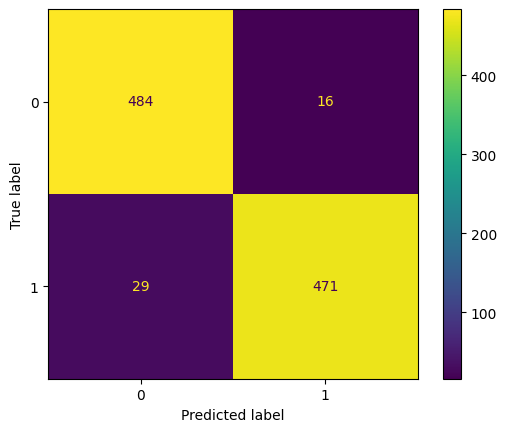

In [ ]:
# Performance metrics
display_performance(y_true, y_pred)

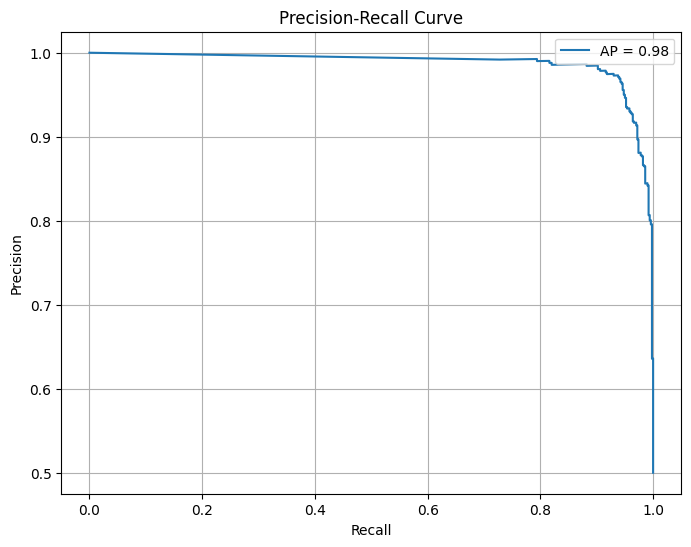

In [ ]:
# Precision recall curve
plot_precision_recall_curve(y_true, y_pred_prob)

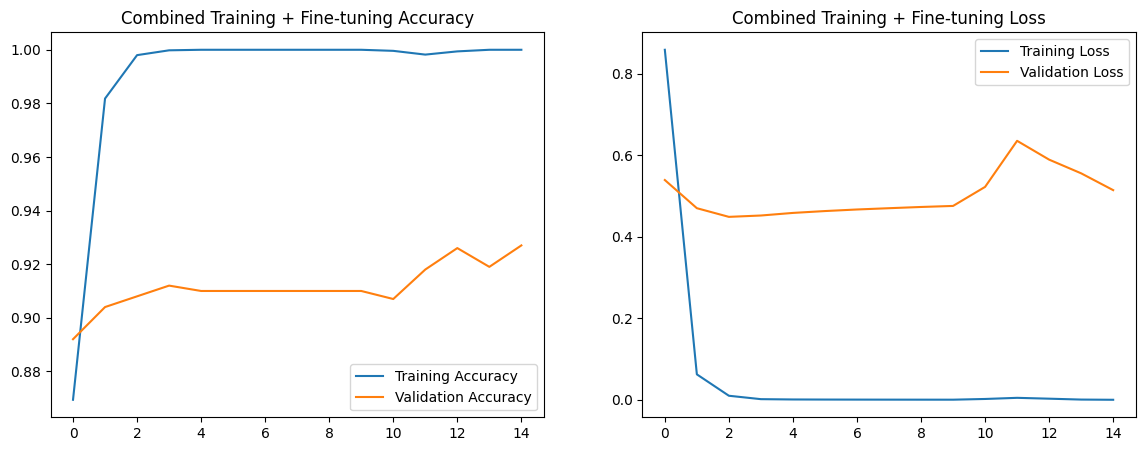

In [ ]:
# Plot Training & Validation Loss / Accuracy Over Epochs
plot_loss_accuracy_over_pochs(history_feedforward, history_feedforward_fine)

**Examine Misclassified Samples**

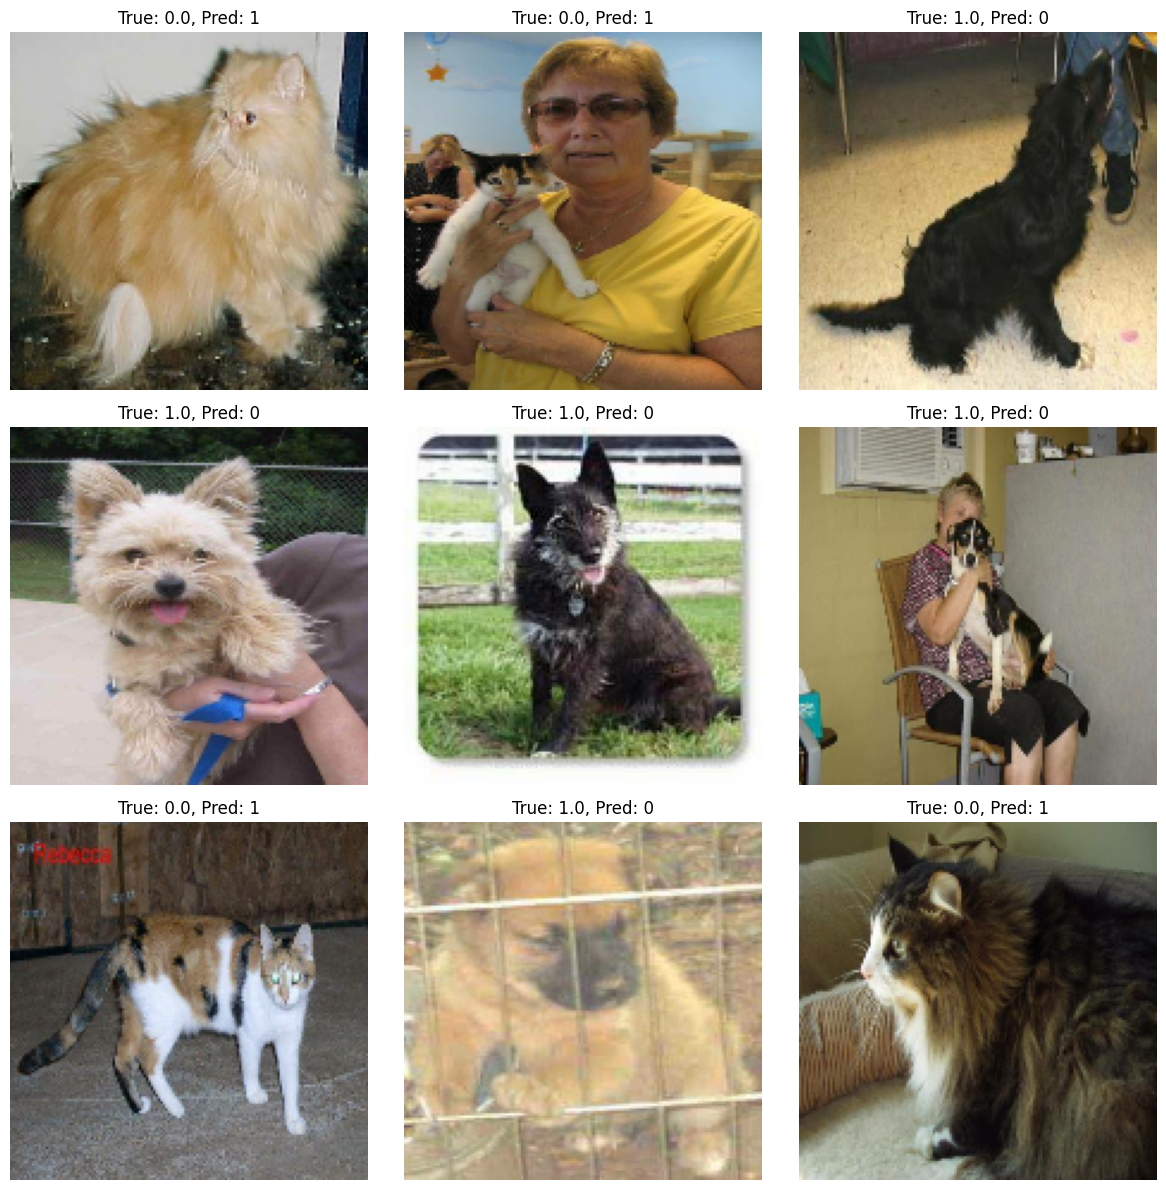

In [ ]:
# plot 9 misclassifed images
plot_misclassified(y_pred, y_true, images_array)

###  2. Transfer Learning Model

**Build model**

In [12]:
# Load VGG16 without the fully connected layers on top
input_shape = (150, 150, 3)
base_model_cnn = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
#Freeze the Convolutional Base
base_model_cnn.trainable = False

# Build the CNN Model
model_cnn = Sequential([
    base_model_cnn,  
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train model**

In [ ]:
# Path to save the best cnn model
best_model_cnn_path = 'models/best_model_cnn.keras'
# Call back to save the best model version
checkpoint_cb_cnn = model_checkpoint_callback(best_model_cnn_path)

# Train the Model
history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb_cnn]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.7401 - loss: 2.1088
Epoch 1: val_accuracy improved from -inf to 0.91600, saving model to models/best_model_cnn.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 882ms/step - accuracy: 0.7406 - loss: 2.1037 - val_accuracy: 0.9160 - val_loss: 0.4460
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.8967 - loss: 0.7264
Epoch 2: val_accuracy improved from 0.91600 to 0.92700, saving model to models/best_model_cnn.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 885ms/step - accuracy: 0.8968 - loss: 0.7257 - val_accuracy: 0.9270 - val_loss: 0.3503
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.9300 - loss: 0.4347
Epoch 3: val_accuracy improved from 0.92700 to 0.92800, saving model to models/best_model_cnn.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 892ms/step - accuracy: 0.9300 - loss: 0.4348 - val_accuracy: 0.9280 - val_loss: 0.3678
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9369 - l

**Fine tune**

In [14]:
# Unfreeze the base model
base_model_cnn.trainable = True

# Freeze all layers up to a specific one
for layer in base_model_cnn.layers[:-4]:
    layer.trainable = False

# Re-Compile with Lower Learning Rate
model_cnn.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower LR!
    metrics=['accuracy']
)

# Fine tune
history_cnn_fine = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[checkpoint_cb_cnn]
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.9604 - loss: 0.1470
Epoch 1: val_accuracy improved from 0.93800 to 0.94300, saving model to models/best_model_cnn.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9605 - loss: 0.1468 - val_accuracy: 0.9430 - val_loss: 0.2438
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.9787 - loss: 0.0661
Epoch 2: val_accuracy did not improve from 0.94300
157/157 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9787 - loss: 0.0661 - val_accuracy: 0.9420 - val_loss: 0.2157
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.9815 - loss: 0.0563
Epoch 3: val_accuracy did not improve from 0.94300
157/157 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9815 - loss: 0.0563 - val_accuracy: 0.9380 - val_loss: 0.2926
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.9903 - loss: 0.0224
Epoch 4: val_accuracy did not improve from 0.94300
157/157 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - a

**Load best model**

In [ ]:
# Load best model
best_model_cnn = load_model(best_model_cnn_path)
# Get true labels and predicted probabilities
y_true_cnn, y_pred_cnn, y_pred_prob_cnn, images_array_cnn = evaluate(best_model_cnn)

Found 1000 files belonging to 2 classes.


**Performance metrics**

✅ Evaluation Metrics:
Accuracy:  0.9660
Precision: 0.9736
Recall:    0.9580
F1 Score:  0.9657

📊 Confusion Matrix:


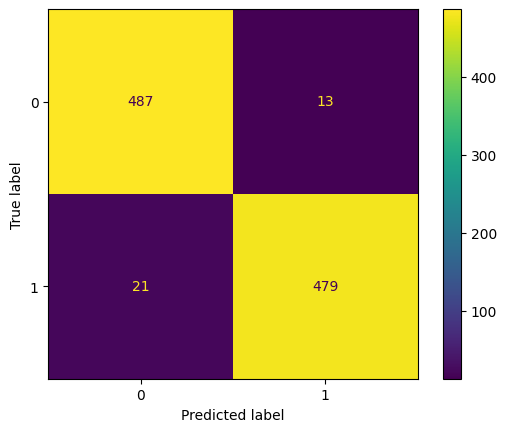

In [24]:
display_performance(y_true_cnn, y_pred_cnn)

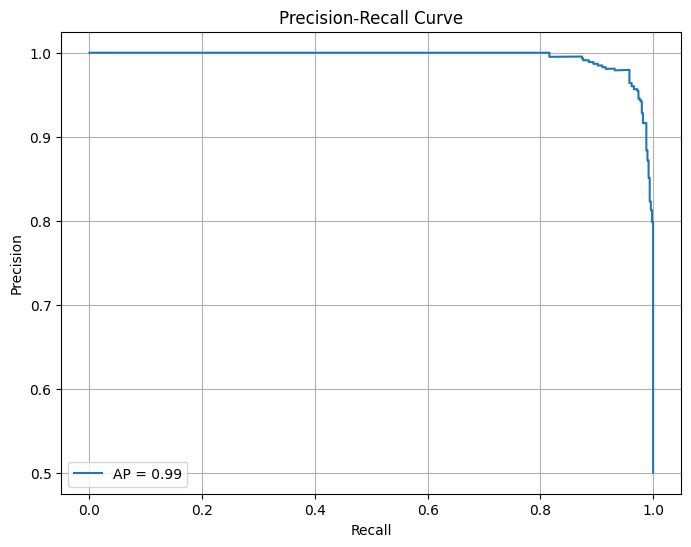

In [17]:
# Precision recall curve
plot_precision_recall_curve(y_true_cnn, y_pred_prob_cnn)

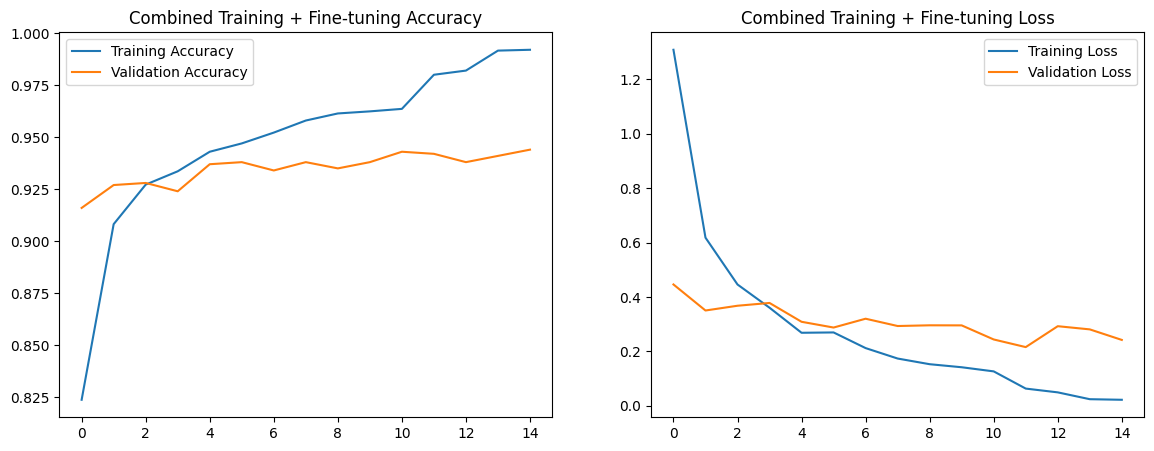

In [18]:
# Plot Training & Validation Loss / Accuracy Over Epochs
plot_loss_accuracy_over_pochs(history_cnn, history_cnn_fine)

**Examine Misclassified Samples**

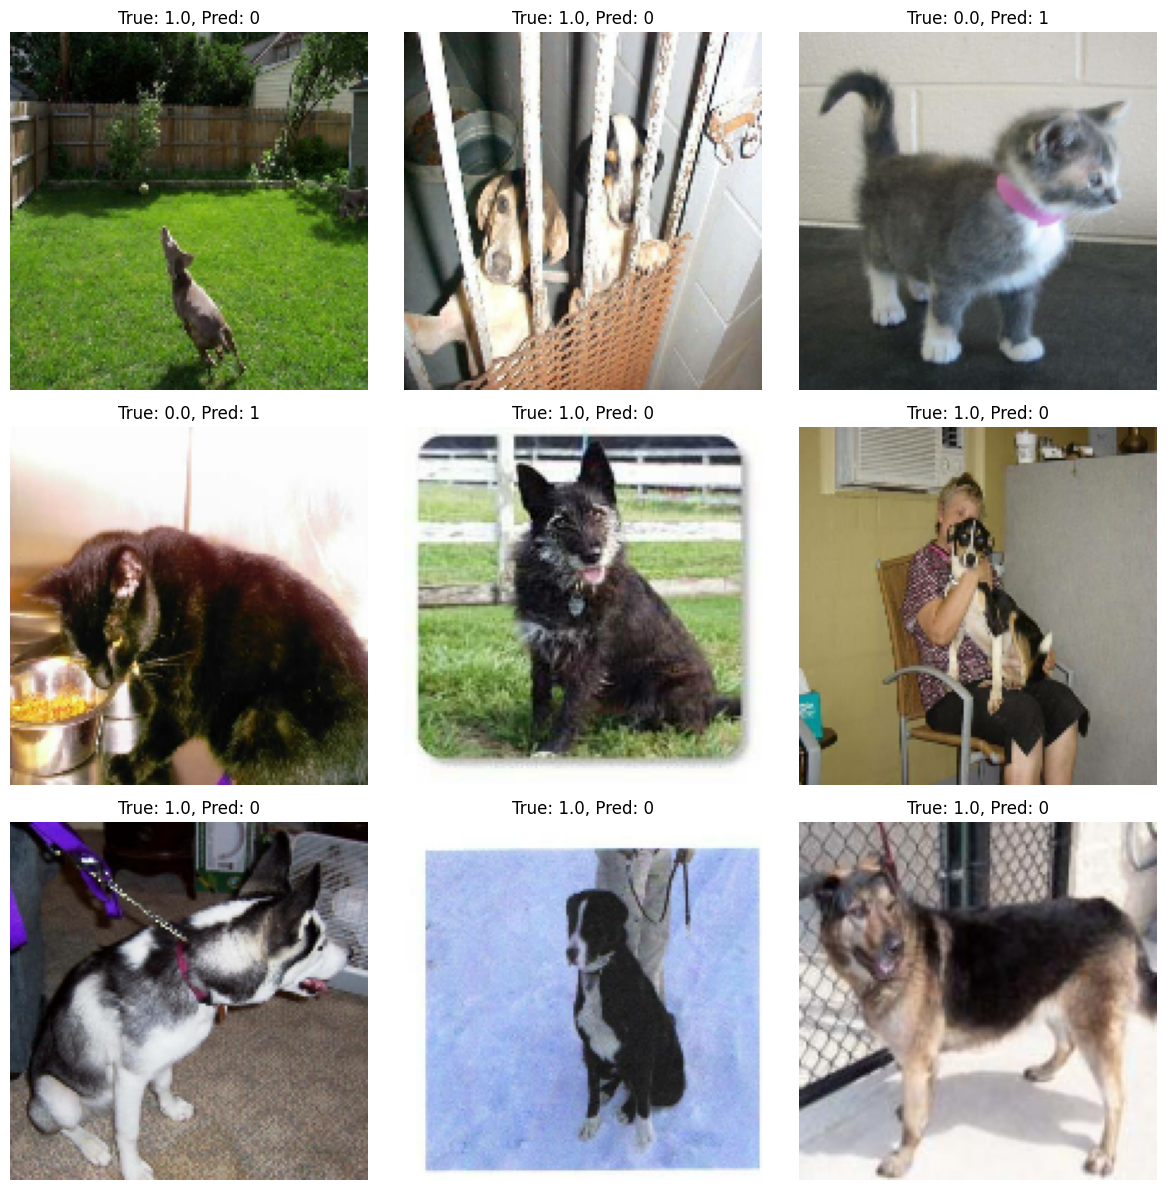

In [19]:
# plot 9 misclassifed images
plot_misclassified(y_pred_cnn, y_true_cnn, images_array_cnn)

## Conclusion
* The transfer learning model achieved higher validation accuracy and lower loss compared to the feedforward neural network.
* With VGG16 as the base model, both the transfer learning model and the feedforward neural network have excellent performance.
* Fine-tuning the top layers of VGG16 led to a slight but consistent improvement in performance.
* Most errors occurred on low-resolution or ambiguous inputs (cat/dog is not the single object, image background has same color as cat/dog, and etc), especially for the FFNN, which lacks convolutional feature extractors.